In [1]:
import torch
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
import openai
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from credentials import hf_auth, openai_key
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig,  TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load PDFs

In [2]:
dirloader = PyPDFDirectoryLoader("../pdfs")
docs = dirloader.load()
len(docs)

598

In [3]:
docs[0]

Document(page_content='2022 Annual Re port\niShares Trust\n•iShares China Lar ge-Cap ETF | FXI | NYSE Arca\n•iShares MSCI China A ETF | CNYA | Cboe BZ XJULY 31, 2022\nBNM0922U-2444952-7653547', metadata={'source': '..\\pdfs\\ar-ishares-china-etfs-07-31.pdf', 'page': 0})

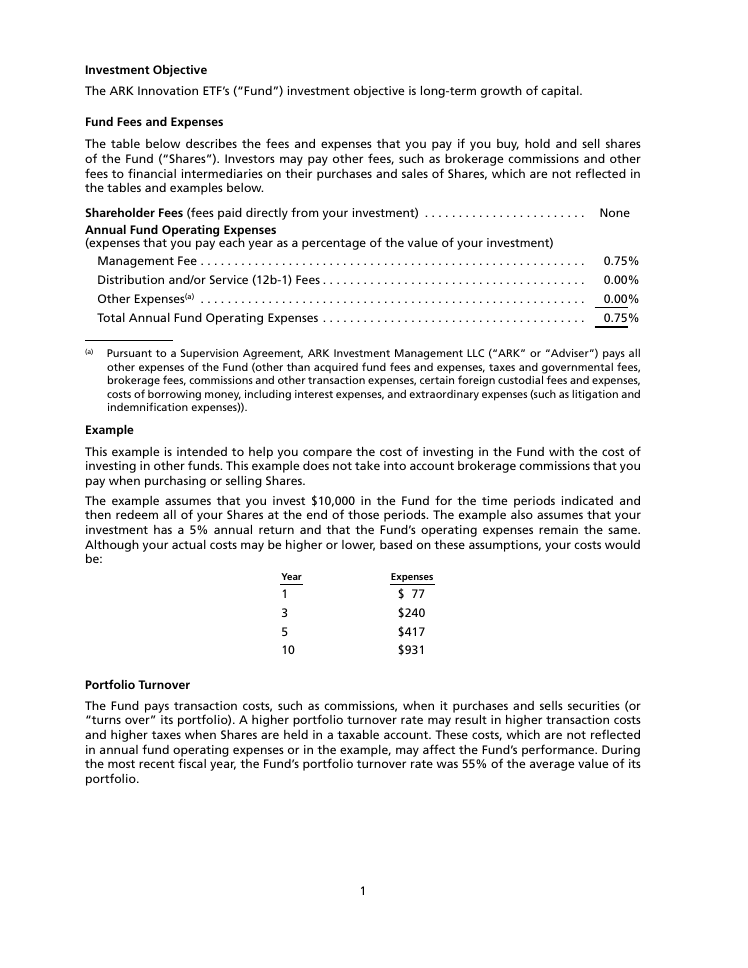

In [3]:
meta_image = convert_from_path("../pdfs/ARKK_Summary_Prospectus.pdf", dpi=88, poppler_path=r'..\poppler-23.08.0\Library\bin')
meta_image[2]

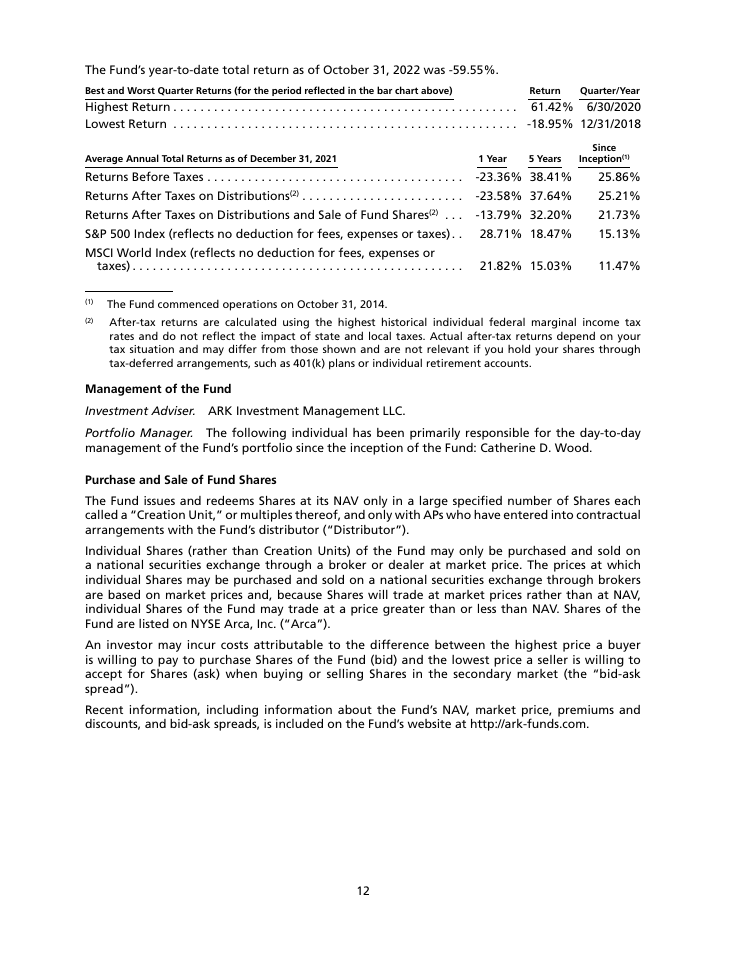

In [14]:
meta_image[13]

In [17]:
loader = PyPDFLoader("../pdfs/ARKK_Summary_Prospectus.pdf")
pages = loader.load()

In [41]:
pages[4]

Document(page_content='3systems; (ii)\xa0develops the building block components for robotics, autonomous technology, \nor AI, such as advanced machinery, semiconductors and databases used for machine learning; \n(iii)\xa0provides its own value-added services on top of such building block components, but \nare not core to the company’s product or service offering; and/or (iv)\xa0develops computer \nsystems that are able to perform tasks that normally require human intelligence, such as \nvisual perception, speech recognition, decision-making, and translation between languages.\n• Next Generation Internet Companies. Companies that the Adviser believes are focused on \nand expected to benefit from shifting the bases of technology infrastructure from hardware \nand software to the cloud, enabling mobile and local services, such as companies that rely \non or benefit from the increased use of shared technology, infrastructure and services. These \ncompanies may include mail order houses whi

In [19]:
len(pages)

16

In [20]:
page = pages[0]

In [22]:
page.metadata

{'source': '../pdfs/ARKK_Summary_Prospectus.pdf', 'page': 0}

# Document Splitting

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024, 
    chunk_overlap=64,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)


In [5]:
texts = text_splitter.split_documents(docs)
len(texts)

2610

In [45]:
print(texts[1])

page_content='Dear Shareholder ,\nThe 12-month reportin g period as o f July 31, 2022 saw the emer gence o f significant challen ges that\ndisrupted the economic recover y and stron g financial markets. The U. S. econom y shrank in the first hal f\nof 2022, endin g the run o f robust growth that followed the reopenin g of global economies and the\ndevelopment o f COVID-19 vaccines. Changes in consumer spendin g patterns and a ti ght labor market\nled to elevated in flation, which reached a 40- year hi gh. Moreover, while the foremost e ffect o f Russia’ s\ninvasion o f Ukraine has been a severe humanitarian crisis, the on going war continued to present\nchallen ges for both investors and polic ymakers.\nEquity prices fell as interest rates rose, particularl y weighing on relativel y high-valuation growth stock s\nand economicall y sensitive small-capitalization stocks. While both lar ge- and small-capitalization U. S.\nstocks fell, declines for small-capitalization U. S. stocks were st

In [32]:
print(texts[2])

page_content='Other Expenses(a) . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.00%\nTotal Annual Fund Operating Expenses . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 0.75%\n(a)    Pursuant to a Supervision Agreement, ARK Investment Management LLC (“ARK” or “Adviser”) pays all \nother expenses of the Fund (other than acquired fund fees and expenses, taxes and governmental fees, \nbrokerage fees, commissions and other transaction expenses, certain foreign custodial fees and expenses, \ncosts of borrowing money, including interest expenses, and extraordinary expenses (such as litigation and \nindemnification expenses)).\nExample\nThis example is intended to help you compare the cost of investing in the Fund with the cost of \ninvesting in other funds. This example does not take into account brokerage commissions that you \npay when purchasing or selling Shares.' metadata={'source': '../pd

In [33]:
print(texts[3])

page_content='pay when purchasing or selling Shares.\nThe example assumes that you invest $10,000 in the Fund for the time periods indicated and \nthen redeem all of your Shares at the end of those periods. The example also assumes that your \ninvestment has a 5% annual return and that the Fund’s operating expenses remain the same. \nAlthough your actual costs may be higher or lower, based on these assumptions, your costs would \nbe:\nYear Expenses\n1 $  77\n3 $ 240\n5 $ 417\n10  $ 931\nPortfolio Turnover\nThe Fund pays transaction costs, such as commissions, when it purchases and sells securities (or \n“turns over” its portfolio). A higher portfolio turnover rate may result in higher transaction costs \nand higher taxes when Shares are held in a taxable account. These costs, which are not reflected \nin annual fund operating expenses or in the example, may affect the Fund’s performance. During \nthe most recent fiscal year, the Fund’s portfolio turnover rate was 55% of the average val

# Embeddings

In [14]:
model_name = "BAAI/bge-small-en"
model_kwargs = {'device': DEVICE}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# Vectorstores

In [44]:
!rm -rf ../chroma  # remove old database files if any

In [46]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory='../chroma')

In [47]:
print(db._collection.count())

2610


## Load the VectorDB

In [15]:
db = Chroma(persist_directory='../chroma', embedding_function=embeddings)

# Llama 2 13B HuggingFace

In [4]:
model_name = "meta-llama/Llama-2-7b-chat-hf"
model_config = AutoConfig.from_pretrained(
    model_name,
    use_auth_token=hf_auth
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=hf_auth)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    config=model_config,
    device_map=DEVICE,
    use_auth_token=hf_auth
)

c:\users\hen1\projects\pdf-qabot\venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HEN1\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


c:\users\hen1\projects\pdf-qabot\venv\lib\site-packages\transformers\tokenization_utils_base.py:1714: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


c:\users\hen1\projects\pdf-qabot\venv\lib\site-packages\transformers\modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 172.00 MiB (GPU 0; 11.00 GiB total capacity; 10.29 GiB already allocated; 0 bytes free; 10.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_token=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

In [ ]:
llm_llama = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature":0})

# OPEN AI

In [10]:
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)

gpt-3.5-turbo-0301


In [11]:
llm_openai = ChatOpenAI(model_name=llm_name, temperature=0, openai_api_key=openai_key)

# Prompt

In [26]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
    [INST]<<SYS>>
    {system_prompt}
    <</SYS>>

    {prompt}[/INST]
    """.strip()

In [27]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
    {context}

    Question: {question}
    """,
    system_prompt = SYSTEM_PROMPT,
)

In [28]:
prompt = PromptTemplate(template=template, input_variables=['context', 'question'])

# Retrieval QA Chian

## Llama 2

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k":2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt":prompt},
)

## Open AI

In [29]:
# Run chain for OPENAI
qa_chain = RetrievalQA.from_chain_type(
    llm_openai,
    retriever=db.as_retriever(search_type="mmr", search_kwargs={'k': 6, 'lambda_mult': 0.75}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt}
)

# Chat with Multiple PDFs(Retrievals)

## Question 1

In [16]:
question_1 = "What is the average 1 year annual total return for iShares China Large-Cap ETF FUND NAV in 2022?"

### Similarity Search

In [52]:
docs_ss = db.similarity_search(question_1,k=6)

In [61]:
docs_ss[1]

Document(page_content='FXIiShares China Large-Cap ETF\nFact Sheet as of 06/30/2023\nThe iShares China Large-Cap ETF seeks to track the investment results of an index \ncomposed of large-capitalization Chinese equities that trade on the Hong Kong Stock \nExchange.\nWHY FXI?\n1Exposure to large companies in China\n2Access to 50 of the largest Chinese stocks in a single fund\n3Use to express a single country view\nGROWTH OF HYPOTHETICAL 10,000 USD SINCE INCEPTION\nFund  Benchmark  \nThe Growth of $10,000 chart reflects a hypothetical $10,000 investment and assumes \nreinvestment of dividends and capital gains. Fund expenses, including management fees and \nother expenses were deducted.\nPERFORMANCE\n1 Year 3 Year 5 Year 10 Year Since Inception\nNAV -17.36% -10.15% -6.83% 0.43% 4.46%\nMarket Price -17.68% -10.03% -6.72% 0.52% 4.45%\nBenchmark -16.62% -9.47% -6.15% 1.18% 5.16%\nThe  performance  quoted  represents  past  performance  and  does  not  guarantee  future', metadata={'page': 0, 

In [54]:
docs_ss[2]

Document(page_content='Supplement to the Summary Prospectus dated as of September 1,\n2022 and the Prospectus and Statement of Additional Informationeach dated as of September 1, 2022 (as revised October 3, 2022):\niShares International Developed Real Estate ETFSupplement to the Summary Prospectus and Prospectus both dated\nas of September 1, 2022 (as revised January 31. 2023), and to theStatement of Additional Information dated as of September 1, 2022(as revised October 3, 2022):\niShares Global Clean Energy ETFSupplement to the Summary Prospectus, Prospectus and Statement\nof Additional Information each dated as of December 1, 2022:\niShares China Large-Cap ETF\niShares Core MSCI EAFE ETFiShares Core MSCI Europe ETFiShares Core MSCI International\nDeveloped Markets ETF\niShares Core MSCI Pacific ETFiShares Core MSCI Total\nInternational Stock ETF\niShares Cybersecurity and Tech ETFiShares ESG MSCI USA Min Vol\nFactor ETF\niShares Exponential Technologies\nETF\niShares Future Cloud 5G

In [58]:
docs_ss[5]

Document(page_content='Calendar Year Total Return as of December 31\n45.30%\n20210%10%20%30%40%50%\nFor the year-to-date period ended  June 30, 2022 , the Fund’s total return was -10.27% . During the period of time shown in \nthe bar chart, the Fund’s highest return  for a calendar quarter was 22.25%  (quarter ended March 31, 2021 ) and the Fund’s \nlowest return  for a calendar quarter was 0.18%  (quarter ended September 30, 2021 ).\nAverage Annual Total Returns\n(for the periods ended December 31, 2021 )\n1 Year Since Inception\n(6/24/20 )\nPacer Lunt Large Cap Alternator ETF\nReturn Before Taxes 45.30% 56.94%\nReturn After Taxes on Distributions 44.85% 56.42%\nReturn After Taxes on Distributions and Sale of Fund Shares 27.01% 44.36%\nLunt Capital U.S. Large Cap Equity Rotation Index\n(reflects no deduction for fees, expenses, or taxes)46.88% 58.63%\nS&P 500® Total Return Index\n(reflects no deduction for fees, expenses, or taxes)28.71% 36.13%', metadata={'page': 187, 'source': '..\\

### MMR(Maximum marginal relevance)

In [59]:
docs_mmr = db.max_marginal_relevance_search(question_1,k=6, fetch_k=30, lambda_mult=0.75)

In [62]:
docs_mmr[1]

Document(page_content='FXIiShares China Large-Cap ETF\nFact Sheet as of 06/30/2023\nThe iShares China Large-Cap ETF seeks to track the investment results of an index \ncomposed of large-capitalization Chinese equities that trade on the Hong Kong Stock \nExchange.\nWHY FXI?\n1Exposure to large companies in China\n2Access to 50 of the largest Chinese stocks in a single fund\n3Use to express a single country view\nGROWTH OF HYPOTHETICAL 10,000 USD SINCE INCEPTION\nFund  Benchmark  \nThe Growth of $10,000 chart reflects a hypothetical $10,000 investment and assumes \nreinvestment of dividends and capital gains. Fund expenses, including management fees and \nother expenses were deducted.\nPERFORMANCE\n1 Year 3 Year 5 Year 10 Year Since Inception\nNAV -17.36% -10.15% -6.83% 0.43% 4.46%\nMarket Price -17.68% -10.03% -6.72% 0.52% 4.45%\nBenchmark -16.62% -9.47% -6.15% 1.18% 5.16%\nThe  performance  quoted  represents  past  performance  and  does  not  guarantee  future', metadata={'page': 0, 

In [65]:
docs_mmr[2]

Document(page_content='-1.20%12.03%\n-11.91%1.74%34.48%\n-12.41%13.74%10.06%\n-21.04%\n1The Fund’s year-to-date return as of September 30, 2022 was -28.85%.\nThe best calendar quarter return during the periods shown above was 14.57% in the\n4th quarter of 2020; the worst was -24.04% in the 3rd quarter of 2015.\nUpdated performance information, including the Fund’s current NAV, may be obtained\nby visiting our website at www.iShares.com or by calling 1-800-iShares (1-800-474-\n2737) (toll free).\nS-10', metadata={'page': 21, 'source': '..\\pdfs\\p-ishares-china-large-cap-etf-7-31-annual-report.pdf'})

### Selfquery

In [17]:
metadata_field_info = [
    AttributeInfo(
        name="source",
        description="The chunk is from, should be one of pdfs in '../pdfs'",
        type="string",
    ),
    AttributeInfo(
        name="page",
        description="The page from the financial pdfs",
        type="integer",
    ),
    AttributeInfo(
        name="year",
        description="The publish year of the source document",
        type="integer",
    ),
    AttributeInfo(
        name="securities",
        description="The security of the chunk is about, it could be ETF, Stock symbol, Mutual Fund",
        type="string",
    ),
]

In [18]:
document_content_description = "Financial Documents"
retriever = SelfQueryRetriever.from_llm(
    llm_openai,
    db,
    document_content_description,
    metadata_field_info,
    verbose=True
)

In [19]:
answers = retriever.get_relevant_documents(question_1)

c:\users\hen1\projects\pdf-qabot\venv\lib\site-packages\langchain\chains\llm.py:279: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


query='iShares China Large-Cap ETF FUND NAV' filter=Operation(operator=<Operator.AND: 'and'>, arguments=[Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='year', value=2022), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='securities', value='ETF'), Comparison(comparator=<Comparator.EQ: 'eq'>, attribute='securities', value='iShares China Large-Cap ETF FUND NAV')]) limit=None


In [20]:
for ans in answers:
    print(ans.metadata)

[]

### Compression

In [90]:
def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))


In [91]:
compressor = LLMChainExtractor.from_llm(llm_openai)

In [93]:
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=db.as_retriever()
)

In [94]:
compressed_docs = compression_retriever.get_relevant_documents(question_1)
pretty_print_docs(compressed_docs)

c:\users\hen1\projects\pdf-qabot\venv\lib\site-packages\langchain\chains\llm.py:279: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Document 1:

iShares China Large-Cap ETF
----------------------------------------------------------------------------------------------------
Document 2:

Average Annual Total Returns
(for the periods ended December 31, 2021 )
1 Year 5 Years Since Inception
(3/10/15 )
Pacer CSOP FTSE China A50 ETF
Return Before Taxes -7.45% 13.37% 8.11%
Return After Taxes on Distributions -7.65% 12.37% 7.00%
Return After Taxes on Distributions and Sale of Fund Shares -3.93% 10.44% 6.25%


### Result from LLM

In [75]:
result_1 = qa_chain(question_1)

In [76]:
result_1["result"]

'The average 1 year annual total return for iShares China Large-Cap ETF FUND NAV in 2022 is -17.36%.'

## Question 2

In [77]:
question_2 = "What is the average 1 year annual total return for iShares China Large-Cap ETF FUND NAV in 2023?"

In [78]:
result_2 = qa_chain(question_2)

In [79]:
result_2["result"]

'As of the given context, the average 1 year annual total return for iShares China Large-Cap ETF FUND NAV in 2023 is -17.36%.'

## Question 3

In [23]:
question_3 = "What is the average 1 year annual total return for ARKK NAV?"

In [30]:
result_3 = qa_chain(question_3)

In [31]:
result_3["result"]

'The average 1 year annual total return for ARKK NAV is 10.41%.'

## Question 4

In [32]:
question_4 = "What is the average 1 year annual total return for PACER US CASH COWS 100 ETF NAV?"

In [33]:
result_4 = qa_chain(question_4)

In [34]:
result_4["result"]

'The average 1 year annual total return for PACER US CASH COWS 100 ETF NAV is 42.48%.'

In [35]:
docs_mmr = db.max_marginal_relevance_search(question_4,k=6, fetch_k=30, lambda_mult=0.75)

In [36]:
docs_mmr[0]

Document(page_content='Average Annual Total Returns\n(for the periods ended December 31, 2021 )\n1 Year 5 Years Since Inception\n(12/16/16 )\nPacer US Cash Cows 100 ETF\nReturn Before Taxes 42.48% 16.25% 15.81%\nReturn After Taxes on Distributions 41.94% 15.67% 15.22%\nReturn After Taxes on Distributions and Sale of Fund Shares 25.48% 12.96% 12.59%\nPacer US Cash Cows 100 Index\n(reflects no deduction for fees, expenses, or taxes) 43.26% 16.71% 16.27%\nRussell 1000® Index\n(reflects no deduction for fees, expenses, or taxes)26.45% 18.43% 18.08%\nAfter-tax returns are calculated using the historical highest individual federal marginal income tax rates during the period \ncovered by the table above and do not reflect the impact of state and local taxes.  Actual after-tax returns depend on an \ninvestor’s tax situation and may differ from those shown.  After-tax returns shown are not relevant to investors who hold \ntheir Shares through tax-deferred arrangements such as an individual reti